# 04_OHT_mooring

### Import packages

In [1]:
%load_ext autoreload
%autoreload 2

# general
import numpy as np, numpy.ma as ma
import xarray as xr
import pandas as pd

# time
from datetime import datetime, timedelta
import calendar
from calendar import monthrange

# local system 
import sys  
import glob
import os

# plotting
import matplotlib as mpl
from matplotlib import pyplot as plt
import matplotlib.colors
import cmocean
import matplotlib.patches as mpatches
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.colors import Normalize
from matplotlib.ticker import MultipleLocator

import matplotlib.dates as mdates

# geo plotting
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeat
from cartopy import img_transform

from metpy.units import units


import shapely
from shapely.geometry import Point
import warnings
from shapely.errors import ShapelyDeprecationWarning
warnings.filterwarnings("ignore", category=ShapelyDeprecationWarning) 

# sys.path.append('../Libraries_functions/')
# from LIB_ASI_SIC_UniB import grab_ASI_SIC

# from LIB_geo_plot import *
# # from LIB_access_ERA5 import shift_bylons
# from LIB_PPdrift_NSIDC0116 import grab_icedrift_range

# path to own functions
sys.path.append('../../')
import plot_simply.general as plotter
import plot_simply.geomap as geomap
import geofunc.vectors as vectors
import data_UniBremen.SIC as UNISIC
import data_OSISAF.icedrift_lr as osidrift
import timeseries.adjust as tseries
import timeseries.analyze as tanalyze
import geofunc.vectors as vectors


### Import data

In [2]:
# Save to file
df = pd.read_csv('../data/constants.csv')
df = df.set_index('var')
df

cst = {}
for variable in list(df.index):
    cst[variable] = df.loc[variable]['value'] * units(df.loc[variable]['units'])
    
cst

{'Cp_o': <Quantity(3850.0, 'joule / kilogram / delta_degree_Celsius')>,
 'Cp_a': <Quantity(1004.0, 'joule / kilogram / delta_degree_Celsius')>,
 'sigma_sb': <Quantity(5.670367e-08, 'watt / meter ** 2 / kelvin ** 4')>,
 'rho_a': <Quantity(1.225, 'kilogram / meter ** 3')>,
 'rho_o': <Quantity(1028.0, 'kilogram / meter ** 3')>,
 'rho_i': <Quantity(917.0, 'kilogram / meter ** 3')>,
 'L_i': <Quantity(334000.0, 'joule / kilogram')>,
 'k_i': <Quantity(2.2, 'watt / meter / delta_degree_Celsius')>,
 'kappa': <Quantity(0.4, 'dimensionless')>,
 'St': <Quantity(0.0057, 'dimensionless')>,
 'omega': <Quantity(7.2921e-05, 'radian / second')>}

In [147]:
#===============================================================

# 2016-2017
# time_range = slice(datetime(2016, 11, 1), datetime(2017, 5, 30,23))

# 2017-2018
time_range = slice(datetime(2017, 11, 1), datetime(2018, 5, 30,23))

# 2018-2019
# time_range = slice(datetime(2018, 12, 1), datetime(2019, 2, 10,23))

#===============================================================

#=============
mooring = 'M1'
#=============

open_years = f'{time_range.start.year}_{time_range.stop.year}'

# calculate projected ESE current component
# u_val = np.cos(157.5 * np.pi/180)
# v_val = np.sin(157.5 * np.pi/180)

DS = xr.open_dataset(f'../data/polynya_size/daily_polynya_{time_range.stop.year}_sic30_v5.nc')
DS = DS.sel(time = time_range)
DS['length'] = (DS['l_per95'] - DS['l_per5'])
# DS['length'] = DS['l_max'] - DS['l_min']


# ocean velocity
#-----------------
ds = xr.open_dataset(f"/Volumes/Seagate_Jewell/KenzieStuff/mooring_data/MARES_moorings/{mooring}/{mooring}_hourly_ocean_currents_{open_years}.nc")
ds.close()
ds = ds.sel(time=time_range)
ds['se'] = vectors.comp_along_theta(ds.u, ds.v, 145*units('deg'))
ds['ne'] = vectors.comp_along_theta(ds.u, ds.v, (90+145)*units('deg'))
ds['speed'] = np.sqrt(ds.u**2+ ds.v**2)

# ocean temperature, sailinity
#-----------------------------
ds2 = xr.open_dataset(f"/Volumes/Seagate_Jewell/KenzieStuff/mooring_data/MARES_moorings/{mooring}/{mooring}_hourly_tempsalinity_{open_years}.nc")
ds2.close()
ds2 = ds2.sel(time=time_range)

ds2['dT'] = ds2.Ct - ds2.Tf

# sea ice velocity
#------------------
ds3 = xr.open_dataset(f"/Volumes/Seagate_Jewell/KenzieStuff/mooring_data/MARES_moorings/{mooring}/{mooring}_hourly_seaice_velocity_{open_years}.nc")
ds3.close()
ds3 = ds3.sel(depth=0, time=time_range)
ds3['se'] = vectors.comp_along_theta(ds3.u, ds3.v, 145*units('deg'))
ds3['speed'] = np.sqrt(ds3.u**2+ ds3.v**2)


ds6 = xr.open_dataset(f'../data/heat_flux/ohf_{time_range.stop.year}_v0.nc')
ds6 = ds6.sel(time=time_range)
ds6.close()


icespeed = np.sqrt(ds3.u**2 + ds3.v**2)

u_sfc = ds3.u.values
v_sfc = ds3.v.values

scf_angle = vectors.vector_angle(u_sfc, v_sfc)



# u_norm = u_sfc / icespeed
# v_norm = v_sfc / icespeed

# u_perp = - v_norm
# v_perp = u_norm

along_sfc = vectors.comp_along_theta(ds.u, ds.v, scf_angle)
perp_sfc  = vectors.comp_along_theta(ds.u, ds.v, scf_angle + 90*units('deg'))


# lat, lon = 70.5, -140 
# ds4 = grab_atm(time_range, lat = lat, lon = lon)
# ds4['speed'] = np.sqrt(ds4.u10**2+ ds4.v10**2)
# ds4['se'] = vectors.comp_along_theta(ds4.u10, ds4.v10, 135*units('deg'))
# wind_along_sfc = (ds4.u10 * u_norm) + (ds4.v10 * v_norm)
# wind_perp_sfc = (ds4.u10 * -v_norm) + (ds4.v10 * u_norm)


### Evaluate data gaps

In [148]:
#===================
retain_frac = 0.95
#===================

print(f'Ocean currents:')
for depth in ds.depth.values[::-1]:
    # finite fraction
    ffrac = np.sum(np.isfinite(ds.u.sel(depth=depth).values)) / len(ds.time)
    print(f'z = {str(depth)} [{ffrac:.2f}] {"*"*(ffrac > retain_frac)}')

print(f'\nOcean temperatures:')
for depth in ds2.depth.values[::-1]:
    # finite fraction
    ffrac = np.sum(np.isfinite(ds2.Ct.sel(depth=depth).values)) / len(ds2.time)
    print(f'z = {str(depth)} [{ffrac:.2f}] {"*"*(ffrac > retain_frac)}')
    
print(f'\nSea ice velocity:')
# finite fraction
ffrac = np.sum(np.isfinite(ds3.u.values)) / len(ds3.time)
print(f'z = {0} [{ffrac:.2f}] {"*"*(ffrac > retain_frac)}')

Ocean currents:
z = -4.0 [0.54] 
z = -6.0 [0.79] 
z = -8.0 [0.91] 
z = -10.0 [0.96] *
z = -12.0 [0.96] *
z = -14.0 [0.95] *
z = -18.0 [0.91] 
z = -22.0 [0.00] 
z = -24.0 [0.84] 
z = -30.0 [0.99] *

Ocean temperatures:
z = -16.0 [1.00] *
z = -22.0 [1.00] *
z = -28.0 [1.00] *
z = -36.0 [0.99] *

Sea ice velocity:
z = 0 [0.85] 


/var/folders/p8/hz449fpx6nscv0jb1klyfqb40000gp/T/ipykernel_39773/362214240.py:9: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  print(f'z = {str(depth)} [{ffrac:.2f}] {"*"*(ffrac > retain_frac)}')
/var/folders/p8/hz449fpx6nscv0jb1klyfqb40000gp/T/ipykernel_39773/362214240.py:15: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  print(f'z = {str(depth)} [{ffrac:.2f}] {"*"*(ffrac > retain_frac)}')
/var/folders/p8/hz449fpx6nscv0jb1klyfqb40000gp/T/ipykernel_39773/362214240.py:20: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  print(f'z = {0} [{ffrac:.2f}] {"*"*(ffrac > retain_frac)}')


<IPython.core.display.Javascript object>


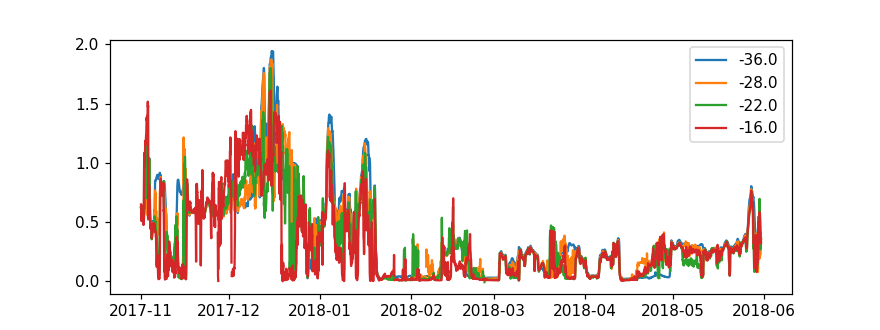

In [149]:
fig, ax = plt.subplots(figsize=(8,3))

for depth in ds2.depth.values:
    
    plt.plot(ds2.time, ds2.dT.sel(depth=depth), label=depth)
    
plt.legend()

In [150]:
np.arange(-170,-11,15)

array([-170, -155, -140, -125, -110,  -95,  -80,  -65,  -50,  -35,  -20])

In [151]:
%matplotlib notebook

<IPython.core.display.Javascript object>


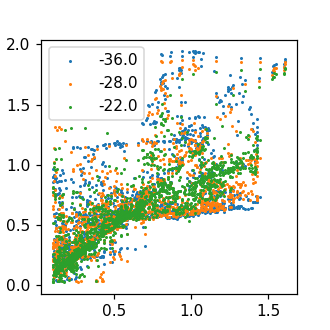

In [152]:
fig, ax = plt.subplots(figsize=(3,3))


cond = (ds.se.mean(dim='depth') > 0.1) & (ds2.dT.sel(depth = -16) > 0.1)


for depth in ds2.depth.values[:-1]:
    ax.scatter(ds2.dT.sel(depth = -16)[cond], ds2.dT.sel(depth = depth)[cond], s=1 ,label=depth)
    
plt.legend()

In [153]:
for depth in ds2.depth.values:
    print(depth)

-36.0
-28.0
-22.0
-16.0


<IPython.core.display.Javascript object>


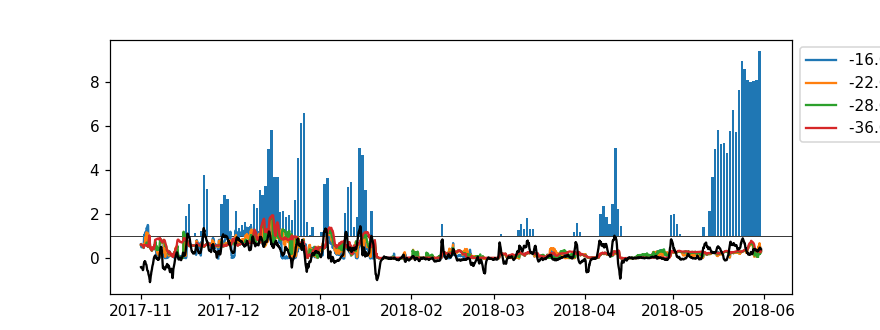

In [154]:
fig, ax = plt.subplots(figsize=(8,3))

# ax.axhline(30, c='k', lw=0.5)
# ax.plot(ds3.time, ds3.se + 30, c='k', label=f'ice se')

yy = 1
ax.axhline(yy, c='k', lw=0.5)
ax.bar(DS.time, DS.extent/1000, align='edge', bottom = yy)

# for depth in ds.depth.values[::-1][:10]:
#     ax.plot(ds.time, ds.se.sel(depth = depth)-ds.se.sel(depth = -7.3), label=f'{depth} m')
    
for depth in ds2.depth.values[::-1]:
    ax.plot(ds2.time, ds2.dT.sel(depth = depth), label=f'{depth} m')
    
    
# ax.plot(ds.time, ds3.se-ds.se.sel(depth = -7.3), c='gray')
# ax.plot(ds.time, ds3.se, c='k')

# plt.pcolormesh(ds2.time, ds2.depth[:-1], ds2.sig0.diff('depth') / ds2.depth.diff('depth'), vmin=-0.25, vmax=0.25, cmap=cmocean.cm.balance)
    
ax.plot(ds.time, ds.se.mean(dim='depth'), c='k')


plt.legend(bbox_to_anchor=(1,1))

# plt.ylim(-2,2)
# plt.ylabel('sig0 (kg/m3)')
# plt.title(mooring)



# Interpolate / Extrapolate velocities

In [155]:
def time_interp(time, data, max_interp):
    
    # time - interp
    data_interp, dt_interp = tseries.linear_interpolate(og_times, og_times, data, max_dt = max_interp)

    return data_interp


def interp_z(z_vals, og_times, data_grid, og_data, og_z, need_interp_z):
    
    d_grid = np.copy(data_grid)
    
    for zz in need_interp_z:
        
        print(zz)

        # find index
        zi = np.where(z_vals == zz)[0][0]

        # find nan times
        iter_tt = np.arange(len(og_times))[np.isnan(d_grid[zi,:])]

        for tt in iter_tt:

            non_nan_zs = og_z[np.isfinite(og_data[:,tt])]
            
            # identify closest non-nan depths above and below
#             non_nan_zs = z_vals[np.isfinite(d_grid[:,tt])]

            if len(non_nan_zs) > 0:
                
                if np.sum(non_nan_zs < zz) > 0 and np.sum(non_nan_zs > zz) > 0:

                    z_abv = non_nan_zs[non_nan_zs > zz].min()
                    z_blw = non_nan_zs[non_nan_zs < zz].max()

                    # grab their indices
                    zi_abv = np.where(og_z == z_abv)[0][0]
                    zi_blw = np.where(og_z == z_blw)[0][0]

                    # interp the values across gap
                    duT = og_data[zi_abv, tt]-og_data[zi_blw, tt]
                    dzT = z_abv-z_blw

                    dzt = zz-z_blw

                    d_grid[zi, tt] = og_data[zi_blw, tt] + dzt*(duT/dzT)

    return d_grid
        
    
    
    
def handle_sfc_nans(og_times, data_grid, method = 'extend'):
    
    zz = z_vals.max() 
    zi0 = np.where(z_vals == zz)[0][0]

    # find nan times
    iter_tt = np.arange(len(og_times))[np.isnan(data_grid[zi0,:])]
    
    for tt in iter_tt:
        
        # identify closest non-nan depths below
        non_nan_zs = z_vals[np.isfinite(data_grid[:,tt])]
        
        # identify closest non-nan depth below
        z_blw = non_nan_zs[non_nan_zs < zz].max()
        zi_blw = np.where(z_vals == z_blw)[0][0]
        
        if str(method) == 'extend':
            # replace surface layer with value at given layer
            data_grid[zi0,tt] = data_grid[zi_blw, tt]
            
        elif str(method) == 'extrapolate':
            # identify 2nd closest non-nan depth below
            z2_blw = non_nan_zs[non_nan_zs < z_blw].max()
            z2i_blw = np.where(z_vals == z2_blw)[0][0]

            # change across defined values
            dz_d = z_blw - z2_blw
            dv_d = data_grid[zi_blw, tt] - data_grid[z2i_blw, tt]
            
            # change across desired range
            dz_u = zz - z2_blw

            # extraploate to final point
            dv_u = dz_u * (dv_d/dz_d)
            
            data_grid[zi0,tt] = dv_u + data_grid[z2i_blw, tt]
            
    return data_grid
            
    
    
def identify_matching_layers(og_data, z_vals, addressed_z):

    # identify exact matching z and those that need interp
    exact_z = []
    need_interp_z = []
    for zi, zz in enumerate(z_vals):
        if zz not in addressed_z:

            if zz in og_z:
                num_nonnan = np.sum(np.isfinite(og_data.sel(depth=zz).values))

                if num_nonnan > 0:
                    exact_z.append(zz)
                else:
                    need_interp_z.append(zz)
            else:
                need_interp_z.append(zz)
                
    return exact_z, need_interp_z


def copy_matching_layers(data_grid, og_data, z_vals, exact_z, max_interp):
    

    # sub in existing ocean currents if direct match
    for zz in exact_z:

        # find index
        zi = np.where(z_vals == zz)[0][0]

        # find og vals
        og_val = og_data.sel(depth=zz).values

        # time-interpolate ice velocities to remove small gaps
        data_grid[zi, :] = time_interp(og_times, og_val, max_interp)

        print(f'z = {zz}: * matching o')
        
    return data_grid
#         addressed_z.append(zz)

#     for zz in need_interp_z:
#         print(f'z = {zz}: -needs interp:')




def handle_bottom_nans(data_grid, og_data, z_vals,  og_times, og_z, max_interp, method = 'extend'):
    
    # (2a) extend lowest velocities across bottom
    #--------------------------------------------
    
    # indices to address
#     zi_s = np.arange(len(z_vals))[z_vals < lowest_z]
    
    if str(method) == 'extend':

        # grab lowest velocity
        data_val = np.array([])
        lowest_zs_used = np.array([])
        
        for time in og_times:
            
            og_crop = og_data.sel(time = time)
            
            low_z = og_z[np.isfinite(og_crop.values)]
            
            if len(low_z) > 0:
                lowest_z = low_z.min()
                lowest_zs_used = np.append(lowest_zs_used, lowest_z)
                data_val = np.append(data_val, og_data.sel(time = time).sel(depth=lowest_z).values  )
            else:
                lowest_zs_used = np.append(lowest_zs_used, np.nan)
                data_val = np.append(data_val, np.nan)
            
#         data_val = og_data.sel(depth=lowest_z).values

        # time-interpolate ice velocities to remove small gaps
        data_interp = time_interp(og_data, data_val, max_interp)

        for tt in range(len(og_times)):
            
            if np.isfinite(lowest_zs_used[tt]):
                zi_max = np.where(z_vals < lowest_zs_used[tt])[0][-1]
                data_grid[:zi_max+1, tt] = data_interp[tt]

            
#             zi_s = [z_vals[z_vals < lowest_z].min() for lowest_z in lowest_zs_used[tt]]

#             for zi in zi_s:

#                 zz = z_vals[zi]

#                 print(f'z = {zz} : {method}')

#                 data_grid[zi, :] = data_interp

    
    elif str(method) == 'extrapolate':
        
        lowest_zs_used = []
        
        for zi in zi_s:

            zz = z_vals[zi]
            
            print(f'z = {zz} : {method}')
            
            for tt in np.arange(len(og_times)):

                # identify closest non-nan depths above
                non_nan_zs = z_vals[np.isfinite(data_grid[:,tt])]

                z_abv = non_nan_zs[non_nan_zs > zz].min()
                zi_abv = np.where(z_vals == z_abv)[0][0]

                # identify 2nd closest non-nan depth above
                z2_abv = non_nan_zs[non_nan_zs > z_abv].min()
                z2i_abv = np.where(z_vals == z2_abv)[0][0]

                # change across defined values
                dz_d = z_abv - z2_abv
                dv_d = data_grid[zi_abv, tt] - data_grid[z2i_abv, tt]

                # change across desired range
                dz_u = zz - z2_abv

                # extraploate to final point
                dv_u = dz_u * (dv_d/dz_d)

                data_grid[zi,tt] = dv_u + data_grid[z2i_abv, tt]

    
    return data_grid, lowest_zs_used

    

In [156]:
# J m-2 s-1

# Cp * dt * sig0 * u 



# A = 10000*40

# J s-1

# Cp * dt * sig0 * u * A
    # dss = ds2
    # og_data = dss['Tf'] 

    # dss = ds2
    # og_data = dss['Ct'] 

    # dss = ds2
    # og_data = dss['Sp'] 

    # dss = ds2
    # og_data = 1000+dss['sig0']

    # og data
    # dss = ds
    # og_data = dss['u']

    # dss = ds
    # og_data = dss['v']





In [157]:

labels = ['Tf', 'Ct', 'Sp', 'sig0', 'u', 'v']
datsts = [ds2, ds2, ds2, ds2, ds, ds]
addons = [0, 0, 0, 1000, 0, 0]


long_names = ['Freezing temperature', 'Conservative temperature', 
              'Seawater density', 'Practical salinity', 
              'Eastward velocity', 'Northward velocity']
all_units = ['degC', 'degC', 'kg/m3', 'psu', 'm/s', 'm/s']


all_data = {}

for lab, dss, add in zip(labels, datsts, addons):

    
    #=========================
    # og data
#     dss = dss
    og_data = add+dss[lab]

    # specify surface conditions
    og_sfc =  np.full(len(dss.time), np.nan)
    # og_sfc =  ds3['v']
    sfc_method = 'extend'

    # specify bottom conditions
    og_bot =  np.full(len(dss.time), np.nan)
    bottom_method = 'extend'

    # max time gap allowed in time interp
    max_interp = 6 * units('hour')

    # new z vals
    z_vals = np.linspace(-40,0,21)
    # z_vals = np.arange(-165,-29,15)
    # z_vals = np.arange(-170,-11,15)
    #=========================

    # time-interpolate surface velocities to remove small gaps
    # sfc_interp = time_interp(og_times, og_sfc, max_interp)
    # data_grid[zi, :] = sfc_interp


    # og grids
    og_times = pd.to_datetime(dss.time)
    og_z = np.copy(dss.depth.values)

    # start empty grid
    data_grid = np.full((len(z_vals), len(dss.time)), np.nan)

    # add in top and bottom values as specified
    data_grid[-1,:] = og_sfc
    data_grid[0,:] = og_bot

    addressed_z = []



    # Directly copying matching layers
    #======================================================
    print(f'\nMiddle layers handling : copy matching layers')
    exact_z, need_interp_z = identify_matching_layers(og_data, z_vals, addressed_z)
    data_grid = copy_matching_layers(data_grid, og_data, z_vals, exact_z, max_interp)


    # Interp where data exist
    #======================================================
    # first just for missing layers
    data_grid = interp_z(z_vals, og_times, data_grid, og_data, og_z,  need_interp_z)

    # Handling the bottom
    #======================================================
    # find lowest velocities
    print(f'\nBottom boundary handling :')
    data_grid, lowest_zs_used = handle_bottom_nans(data_grid, og_data, z_vals, 
                                   og_times,og_z, max_interp, method = bottom_method)




    # Handling the surface
    #======================================================
    # find index of surface
    # zi = np.where(z_vals == 0)[0][0]
    data_grid = handle_sfc_nans(og_times, data_grid, method = sfc_method)

    print(f'\nTop boundary handling :')
    print(f'z = {0}: * matching surface')
    # addressed_z.append(z_vals[zi])


    # (5) Handling missing data in surface-most layer
    #======================================================
    # extend nearest-to-sfc. values to the surface
    # find index of surface-most layer
    # data_grid = handle_sfc_nans(og_times, data_grid, method = sfc_method)


    # (6) Handling missing data in middle layers
    #======================================================    
    # then once more across all layers to fill gaps
    # fill from newly-filled grid
    data_grid = interp_z(z_vals, og_times, data_grid, data_grid, z_vals,  z_vals[z_vals!=0])


    all_data[lab] = data_grid


Middle layers handling : copy matching layers
z = -36.0: * matching o
z = -28.0: * matching o
z = -22.0: * matching o
z = -16.0: * matching o
-40.0
-38.0
-34.0
-32.0
-30.0
-26.0
-24.0
-20.0
-18.0
-14.0
-12.0
-10.0
-8.0
-6.0
-4.0
-2.0
0.0

Bottom boundary handling :

Top boundary handling :
z = 0: * matching surface
-40.0
-38.0
-36.0
-34.0
-32.0
-30.0
-28.0
-26.0
-24.0
-22.0
-20.0
-18.0
-16.0
-14.0
-12.0
-10.0
-8.0
-6.0
-4.0
-2.0

Middle layers handling : copy matching layers
z = -36.0: * matching o
z = -28.0: * matching o
z = -22.0: * matching o
z = -16.0: * matching o
-40.0
-38.0
-34.0
-32.0
-30.0
-26.0
-24.0
-20.0
-18.0
-14.0
-12.0
-10.0
-8.0
-6.0
-4.0
-2.0
0.0

Bottom boundary handling :

Top boundary handling :
z = 0: * matching surface
-40.0
-38.0
-36.0
-34.0
-32.0
-30.0
-28.0
-26.0
-24.0
-22.0
-20.0
-18.0
-16.0
-14.0
-12.0
-10.0
-8.0
-6.0
-4.0
-2.0

Middle layers handling : copy matching layers
z = -36.0: * matching o
z = -28.0: * matching o
z = -22.0: * matching o
z = -16.0: * 

In [158]:
data_vars = {}
for lab, long_name, unit in zip(labels, long_names, all_units):
    data_vars[lab] = (("z","time"), all_data[lab], {'long_name': long_name, 'units': unit})

coords={"time": dss.time.values, "z": z_vals}

dsc = xr.Dataset(data_vars, coords=coords, 
                attrs={'description':'regridded variables needed in OHT. Extend V, T, S, Sig values to sfc/bottom. Extend highest currents to surface, and extend lowest currents to bottom.',})


<IPython.core.display.Javascript object>


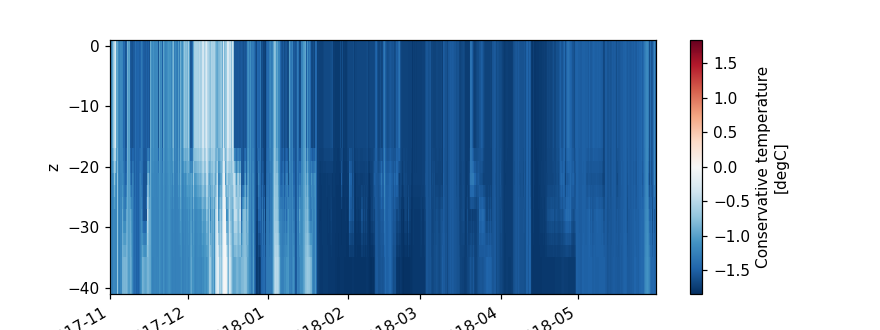

In [159]:
fig, ax = plt.subplots(figsize=(8,3))
dsc.Ct.plot()

In [127]:
# save to file
mainpath = f'/Volumes/Seagate_Jewell/KenzieStuff/mooring_data/MARES_moorings/{mooring}/regridded/'
filename = f"{mooring}_OHT_{open_years}_v1.nc"
dsc.to_netcdf(mainpath+filename)


In [77]:
# data_vars = {}
# data_vars[f'Tf'] = (("z","time"),Tf_grid, {'long_name': 'Freezing temperature', 'units': 'degC'})
# data_vars[f'CT'] = (("z","time"), CT_grid, {'long_name': 'Conservative temperature', 'units': 'degC'})
# data_vars[f'sig0'] = (("z","time"), Sig_grid, {'long_name': 'seawater density', 'units': 'kg/m3'})
# data_vars[f'Sp'] = (("z","time"), Sp_grid, {'long_name': 'Practical salinity', 'units': 'psu'})
# data_vars[f'u'] = (("z","time"), u_grid, {'long_name': 'eastward velocity', 'units': 'm/s'})
# data_vars[f'v'] = (("z","time"), v_grid, {'long_name': 'northward velocity', 'units': 'm/s'})

# coords={"time": dss.time.values, "z": z_vals}

# dsc = xr.Dataset(data_vars, coords=coords, 
#                 attrs={'description':'regridded variables needed in OHT. Extend V, T, S, Sig values to sfc/bottom. Extend highest currents to surface, and extend lowest currents to bottom.',})


# # save to file
# mainpath = f'/Volumes/Seagate_Jewell/KenzieStuff/mooring_data/MARES_moorings/{mooring}/regridded/'
# filename = f"{mooring}_OHT_{open_years}_v1.nc"
# dsc.to_netcdf(mainpath+filename)


<IPython.core.display.Javascript object>


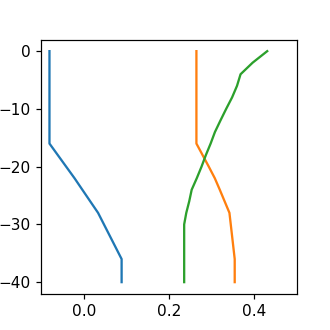

(-0.1, 0.5)

In [190]:
fig, ax = plt.subplots(figsize=(3,3))
plt.plot((np.mean(S_grid, axis=1)-1026)/5, z_vals)
plt.plot(np.mean(T_grid, axis=1), z_vals)
# plt.plot(np.mean(np.sqrt(u_grid**2+v_grid**2), axis=1), z_vals)
plt.plot(np.mean(np.sqrt(u_grid**2+v_grid**2), axis=1), z_vals)

plt.xlim(-0.1,0.5)

<IPython.core.display.Javascript object>


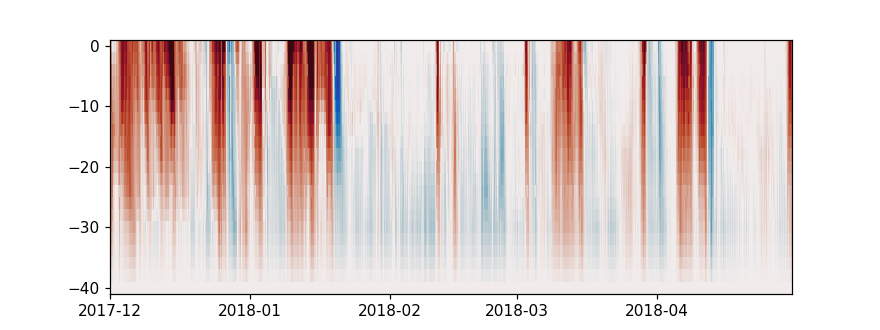

<IPython.core.display.Javascript object>


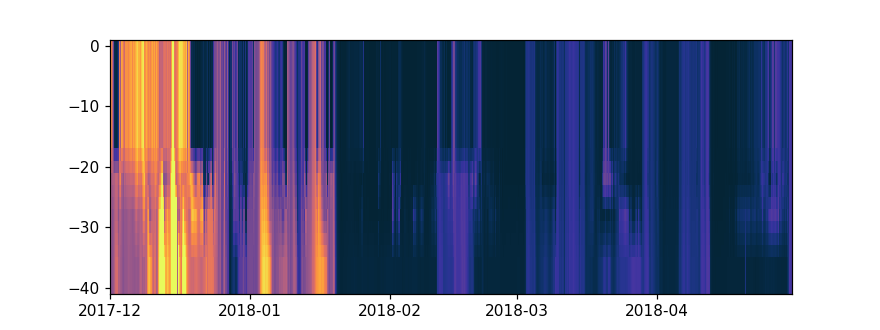

<IPython.core.display.Javascript object>


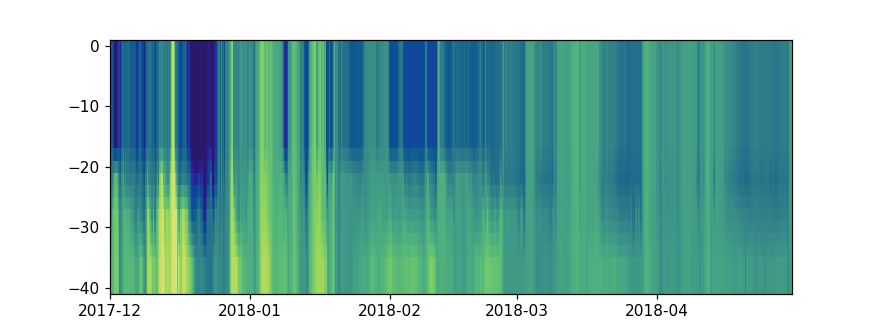

In [156]:
fig, ax = plt.subplots(figsize=(8,3))
plt.pcolormesh( dss.time, z_vals, v_grid_v2, cmap=cmocean.cm.balance, vmin=-1, vmax=1)

fig, ax = plt.subplots(figsize=(8,3))
plt.pcolormesh( dss.time, z_vals, T_grid, cmap=cmocean.cm.thermal, vmin=0, vmax=1.5)

fig, ax = plt.subplots(figsize=(8,3))
plt.pcolormesh( dss.time, z_vals, S_grid-1000, cmap=cmocean.cm.haline, vmin=24, vmax=28)


<IPython.core.display.Javascript object>


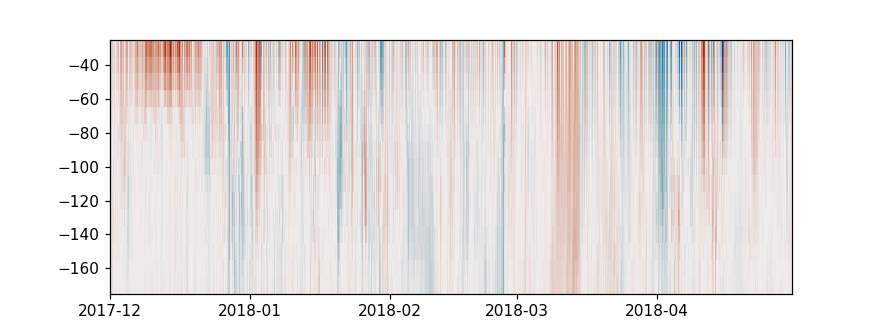

<IPython.core.display.Javascript object>


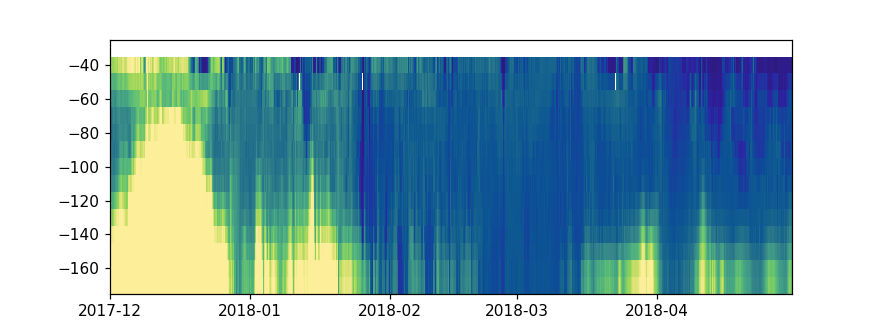

In [29]:
fig, ax = plt.subplots(figsize=(8,3))
plt.pcolormesh( dss.time, z_vals, data_grid, cmap=cmocean.cm.balance, vmin=-1, vmax=1)

fig, ax = plt.subplots(figsize=(8,3))
plt.pcolormesh( dss.time, z_vals, data_grid2, cmap=cmocean.cm.haline, vmin=0, vmax=1500)


In [170]:
u_grid = v_grid_v2 * units('m/s')
ts_grid = S_grid*T_grid * units('delta_degC kg/m3')

hf = cst['Cp_o'] * u_grid * ts_grid

# positive-only heat flux
phf = np.copy(hf)
phf[phf<0* hf.units] = 0 * hf.units

cumH = np.cumsum(np.nansum(hf, axis=0) * 1 * units('hour').to('s')) * 2*units('m') * 20*units('km').to('m')
cumH

<Quantity([3.47494873e+15 6.93020553e+15 1.03086800e+16 ... 2.33265515e+18
 2.33388050e+18 2.33514749e+18], 'joule')>

<IPython.core.display.Javascript object>


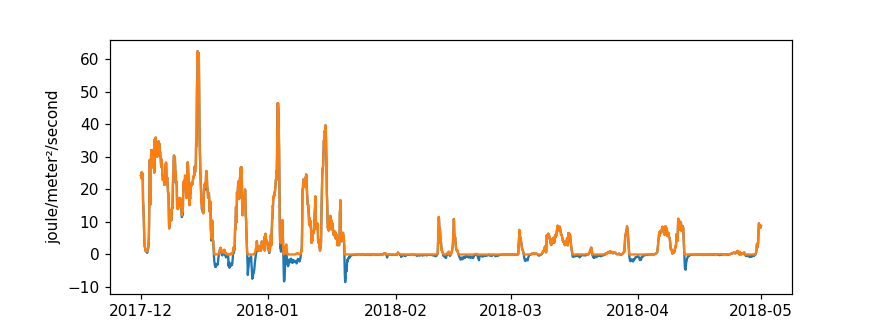

<IPython.core.display.Javascript object>


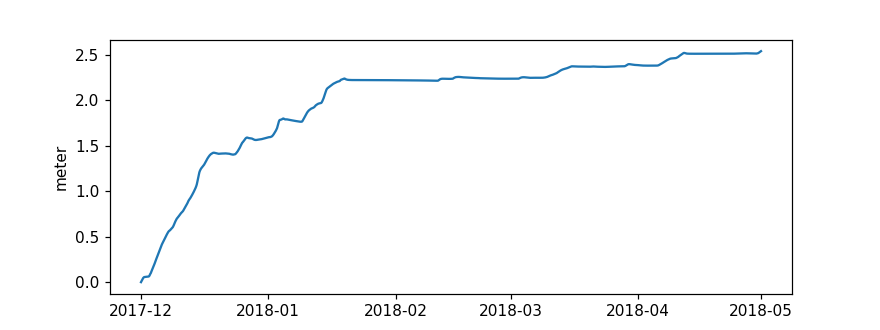

In [175]:
fig, ax = plt.subplots(figsize=(8,3))

plt.plot(dss.time, np.nansum(hf, axis=0)/1000000)
plt.plot(dss.time, np.nansum(phf, axis=0)/1000000)
# plt.bar(DS.time, DS.extent.values/1000, color='k')

fig, ax = plt.subplots(figsize=(8,3))
plt.plot(dss.time, (cumH/(cst['L_i'] * cst['rho_i']*(30*units('km').to('m'))*(100*units('km').to('m')))).to('m'))


In [30]:
u_grid = data_grid * units('m/s')
ts_grid = data_grid2 * units('delta_degC kg/m3')

hf = cst['Cp_o'] * u_grid * ts_grid

# positive-only heat flux
phf = np.copy(hf)
phf[phf<0* hf.units] = 0 * hf.units

In [21]:
# data_grid2 = data_grid

<IPython.core.display.Javascript object>


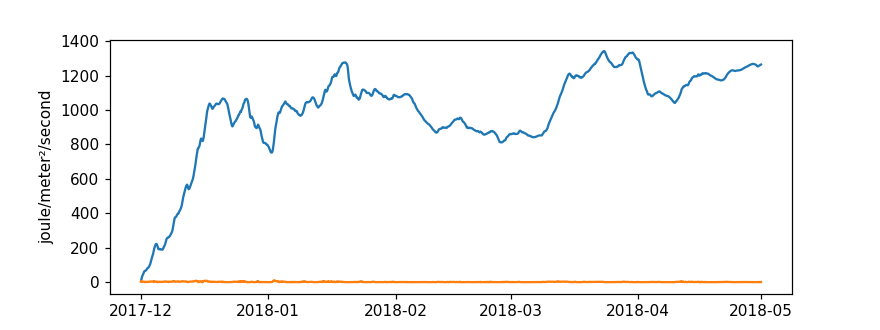

In [55]:
fig, ax = plt.subplots(figsize=(8,3))

plt.plot(dss.time, np.cumsum(np.nansum(hf, axis=0))/1000000)
plt.plot(dss.time, np.nansum(phf, axis=0)/1000000)
# plt.bar(DS.time, DS.extent.values/1000, color='k')


In [77]:
cumH = np.cumsum(np.nansum(hf, axis=0) * 1 * units('hour').to('s')) * 10*units('m') * 30*units('km').to('m')
cumH

<Quantity([4.66068175e+15 1.07019902e+16 1.58550775e+16 ... 1.36414703e+18
 1.36520175e+18 1.36589305e+18], 'joule')>

<IPython.core.display.Javascript object>


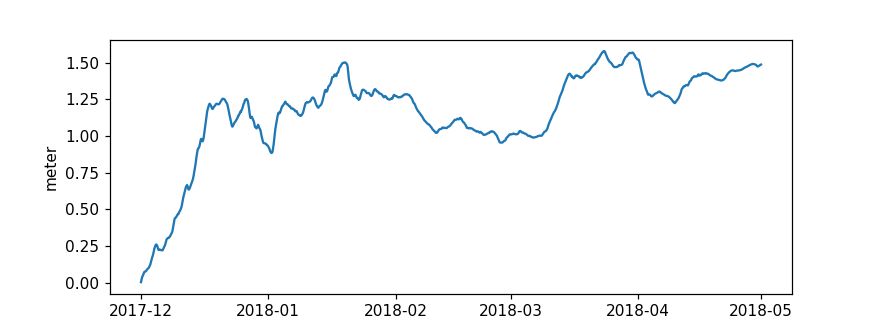

In [79]:
fig, ax = plt.subplots(figsize=(8,3))
plt.plot(dss.time, (cumH/(cst['L_i'] * cst['rho_i']*(30*units('km').to('m'))*(100*units('km').to('m')))).to('m'))

In [ ]:
cst['L_i'] * cst['rho_i']

<IPython.core.display.Javascript object>


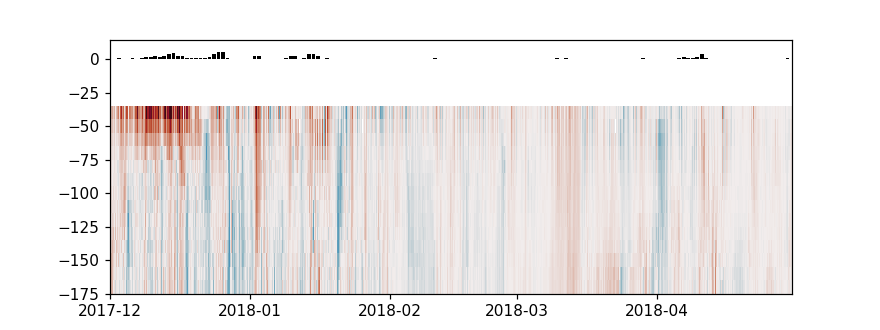

<BarContainer object of 151 artists>

In [50]:

fig, ax = plt.subplots(figsize=(8,3))
plt.pcolormesh( dss.time, z_vals, hf, cmap=cmocean.cm.balance, vmin=-2000000, vmax=2000000)
plt.bar(DS.time, DS.extent/1000, color='k')

<IPython.core.display.Javascript object>


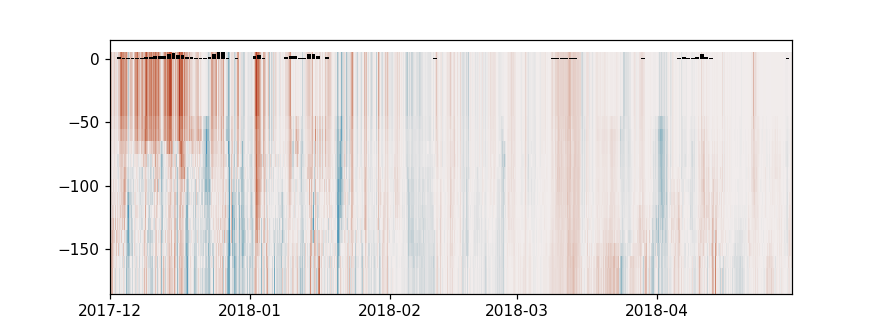

<BarContainer object of 151 artists>

In [199]:

fig, ax = plt.subplots(figsize=(8,3))
plt.pcolormesh( dss.time, z_vals, hf, cmap=cmocean.cm.balance, vmin=-2000000, vmax=2000000)
plt.bar(DS.time, DS.extent/1000, color='k')

In [229]:
z_vals[-10:-5]

array([-90, -80, -70, -60, -50])

In [240]:
z_vals[-18:-13]

array([-170, -160, -150, -140, -130])

<IPython.core.display.Javascript object>


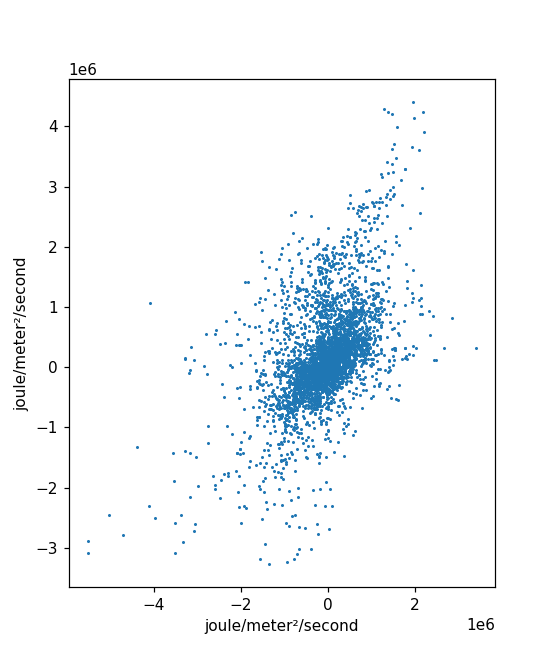

In [241]:
fig, ax = plt.subplots(figsize=(5,6))

plt.scatter(np.sum(hf[-18:-13, :], axis=0), np.sum(hf[-10:-5,:], axis=0), s=1)

<IPython.core.display.Javascript object>


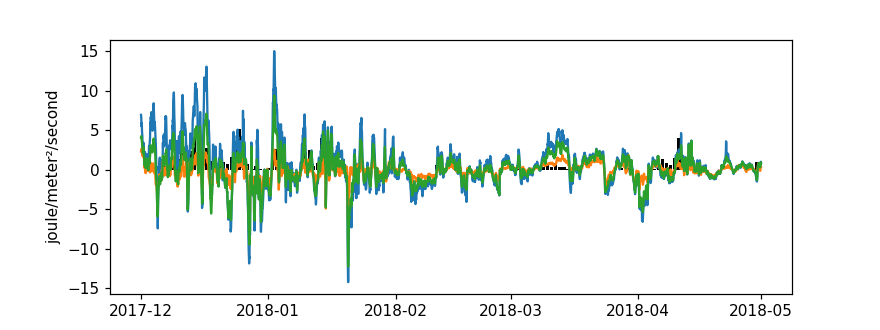

In [220]:
fig, ax = plt.subplots(figsize=(8,3))
plt.bar(DS.time, DS.extent.values/1000, color='k')
plt.plot( dss.time, np.sum(hf, axis=0)/1000000)
plt.plot( dss.time, np.sum(hf[:-13,:], axis=0)/1000000)
plt.plot( dss.time, np.sum(hf[:-5,:], axis=0)/1000000)

<IPython.core.display.Javascript object>


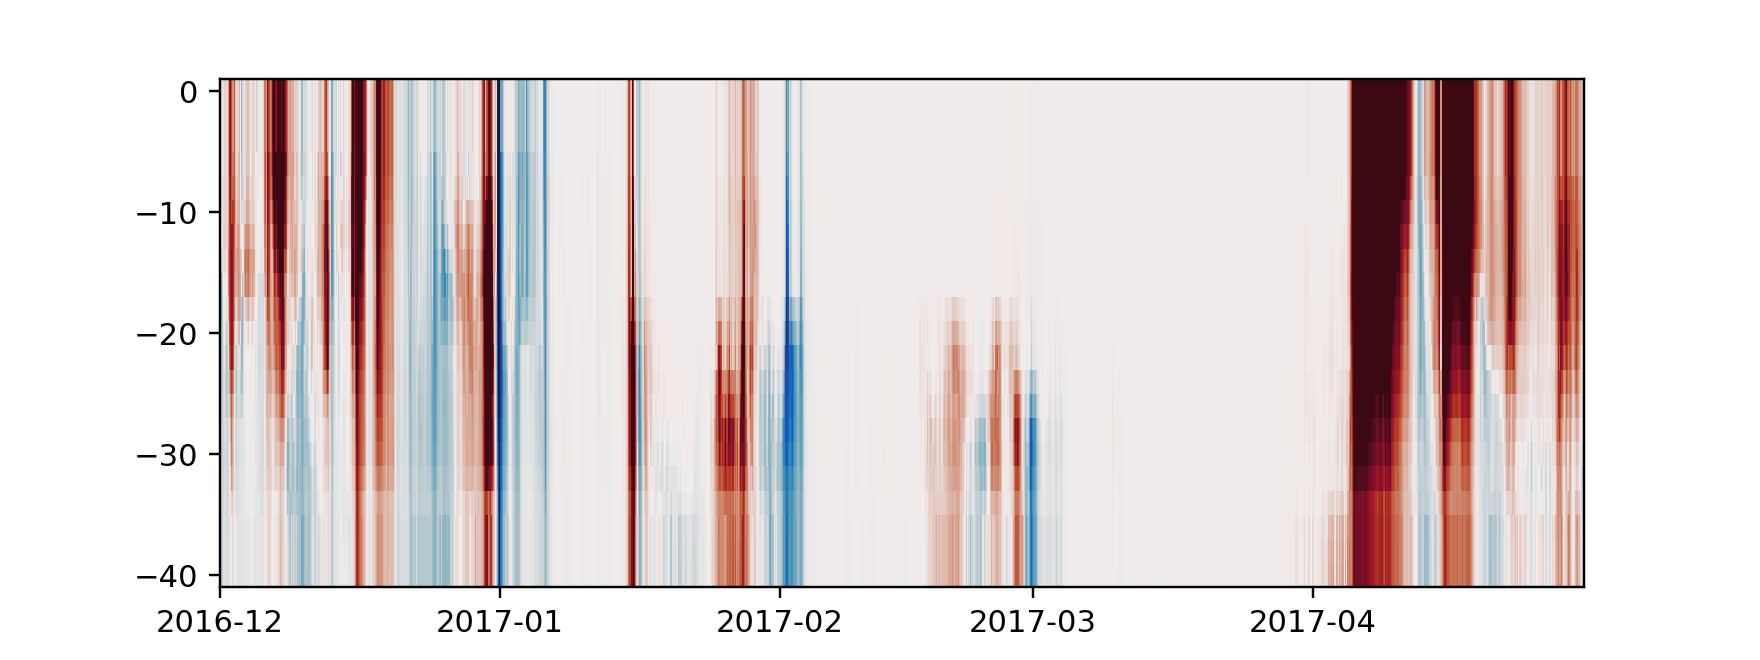

In [136]:

fig, ax = plt.subplots(figsize=(8,3))
plt.pcolormesh( dss.time, z_vals, hf, cmap=cmocean.cm.balance, vmin=-2000000, vmax=2000000)
# plt.contour( dss.time, z_vals, ts_grid, levels=[500], colors=['gold'])


<IPython.core.display.Javascript object>


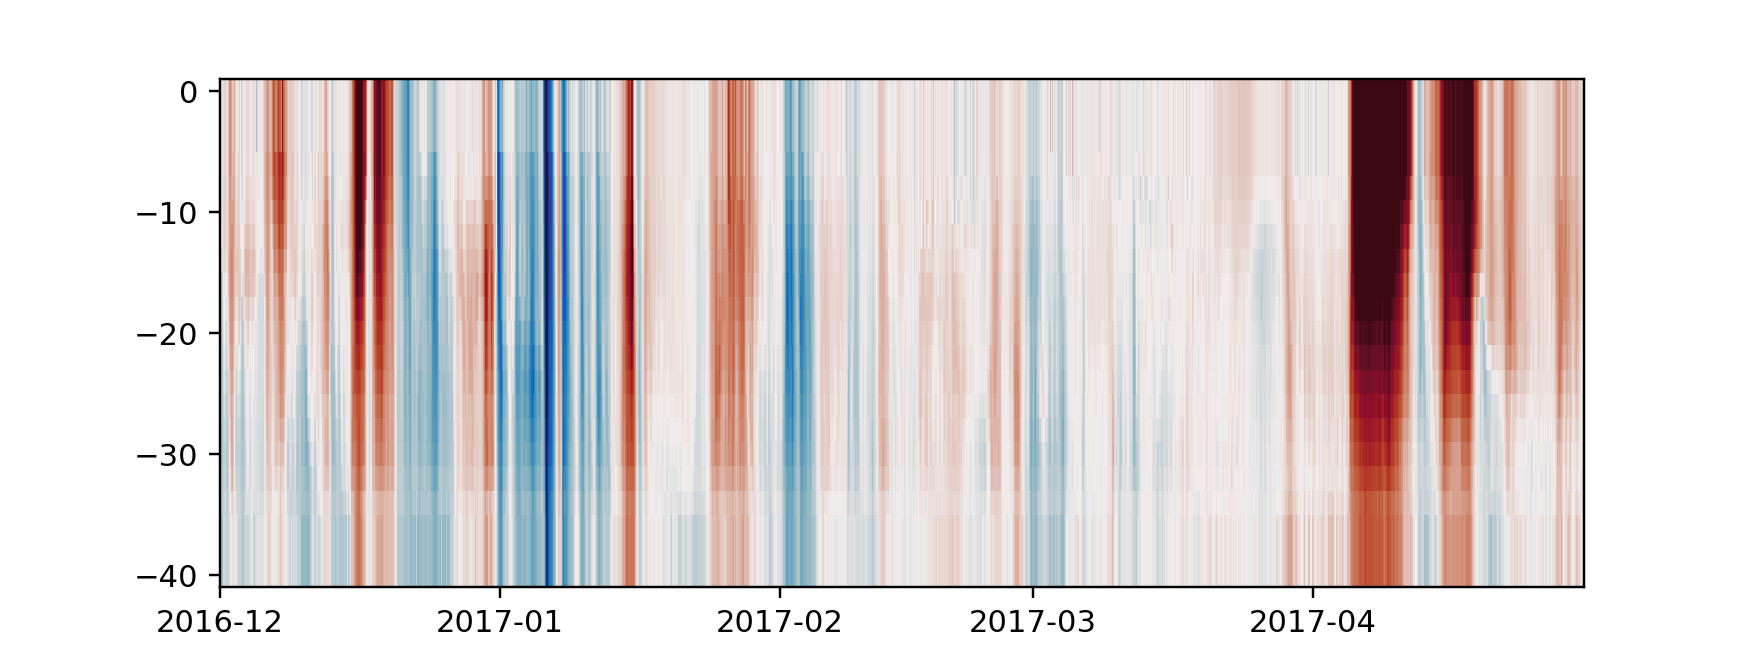

In [130]:

fig, ax = plt.subplots(figsize=(8,3))
plt.pcolormesh( dss.time, z_vals, data_grid2, cmap=cmocean.cm.balance, vmin=-1, vmax=1)


<IPython.core.display.Javascript object>


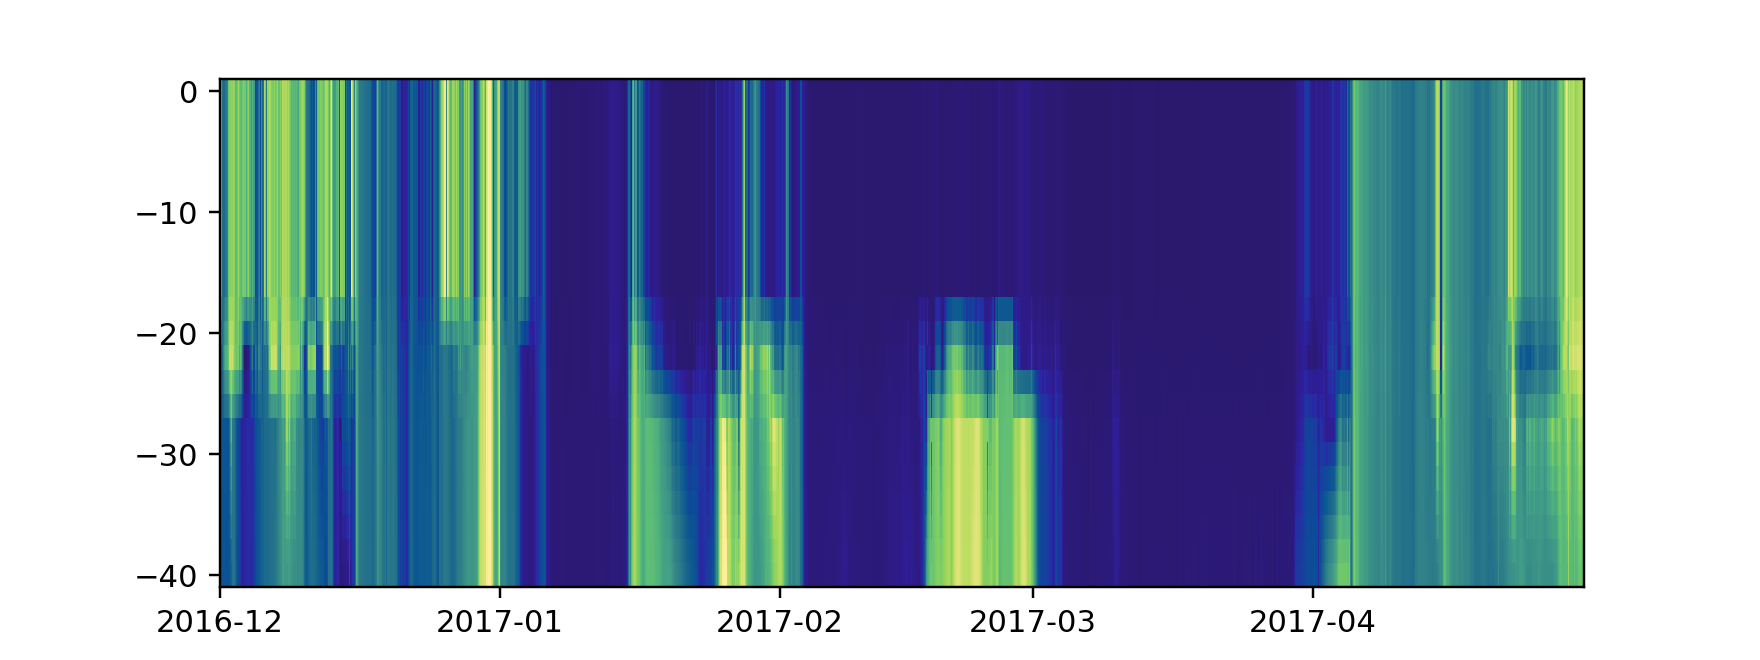

In [138]:

fig, ax = plt.subplots(figsize=(8,3))
plt.pcolormesh( dss.time, z_vals, data_grid, cmap=cmocean.cm.haline, vmin=0, vmax=1500)


In [141]:
DS

<xarray.Dataset>
Dimensions:               (time: 151)
Coordinates:
  * time                  (time) datetime64[ns] 2016-12-01 ... 2017-04-30
Data variables: (12/25)
    N                     (time) float64 ...
    extent                (time) float64 nan nan nan nan nan ... nan nan nan nan
    l_min                 (time) float64 ...
    l_max                 (time) float64 ...
    l_mean                (time) float64 ...
    l_per5                (time) float64 ...
    ...                    ...
    ice_extent            (time) float64 ...
    ocean_extent          (time) float64 ...
    other_polynya_extent  (time) float64 ...
    polynya_extent        (time) float64 ...
    miss_flag             (time) bool ...
    length                (time) float64 nan nan nan nan nan ... nan nan nan nan

In [151]:
z_vals[10:]

array([-20., -18., -16., -14., -12., -10.,  -8.,  -6.,  -4.,  -2.,   0.])

<IPython.core.display.Javascript object>


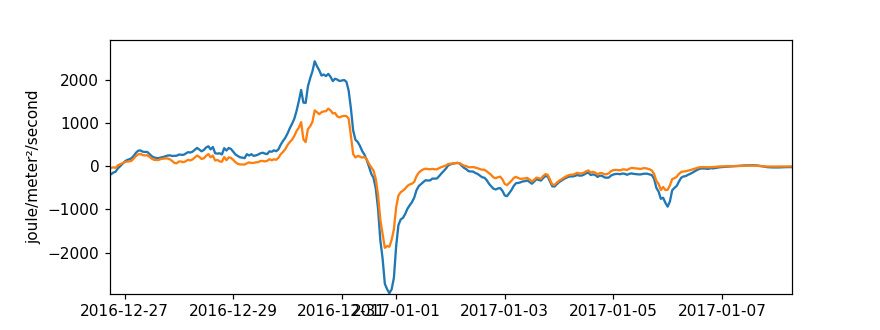

<BarContainer object of 151 artists>

In [181]:
fig, ax = plt.subplots(figsize=(8,3))
plt.plot( dss.time, np.sum(hf, axis=0)/20000)
plt.plot( dss.time, np.sum(hf[10:,:], axis=0)/20000)
plt.bar(DS.time, DS.extent.values, align='edge', color='k')



In [86]:
lowest_zs_used

array([-35.3, -35.3, -35.3, ..., -33.3, -33.3, -33.3])

<IPython.core.display.Javascript object>


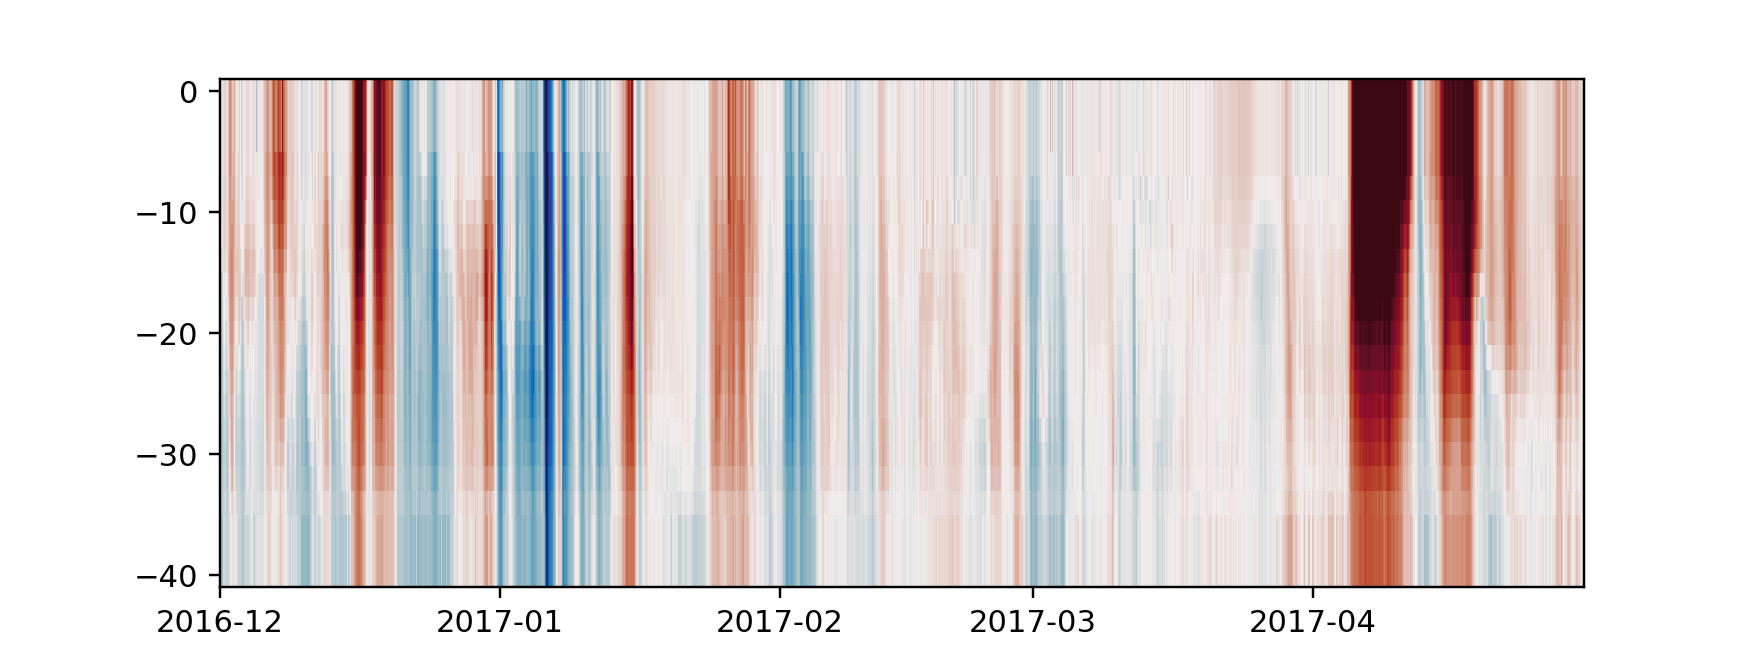

In [103]:

fig, ax = plt.subplots(figsize=(8,3))
plt.pcolormesh( dss.time, z_vals, data_grid, cmap=cmocean.cm.balance, vmin=-1, vmax=1)

# plt.pcolormesh( dss.time, z_vals, data_grid, cmap=cmocean.cm.haline, vmin=0, vmax=1200)

<IPython.core.display.Javascript object>


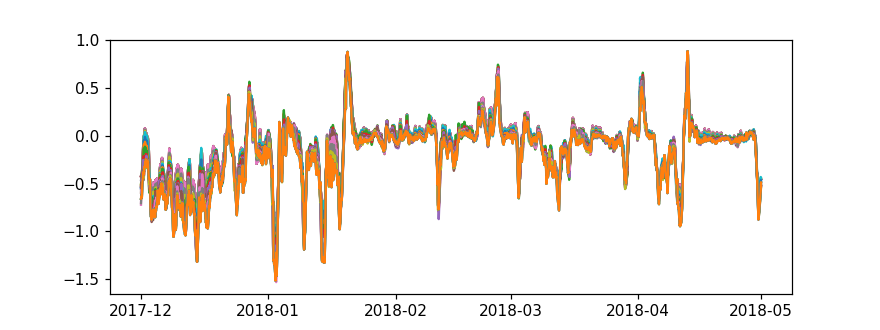

In [841]:
fig, ax = plt.subplots(figsize=(8,3))

plt.plot(dss.time,np.mean(data_grid, axis=0))

for zi, zz in enumerate(z_vals):

    plt.plot(dss.time,  data_grid[zi, :])

<IPython.core.display.Javascript object>


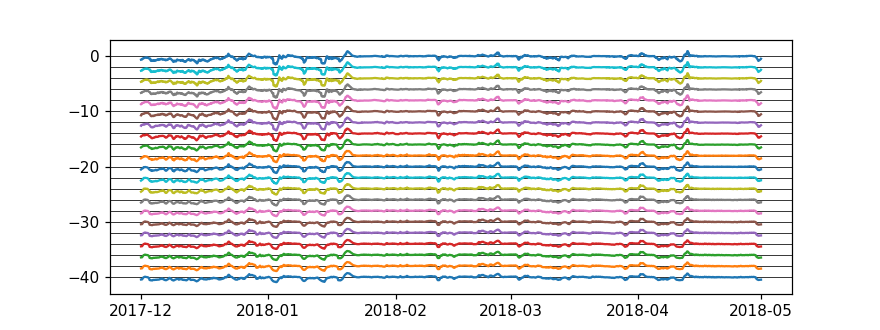

In [843]:
fig, ax = plt.subplots(figsize=(8,3))
# plt.pcolormesh(ds.time, z_vals, u_grid)

for zi, zz in enumerate(z_vals):
    
    plt.axhline(zz, c='k', lw=0.5)
    plt.plot(dss.time,  zz+ data_grid[zi, :])


## Calculate Integrated Ocean Heat Content

Use trapezoidal rule to estimate integrate ocean heat content
OHC = $\sum{\frac{1}{2} [f(x_i) + f(x_{i+1})}] \Delta x$

$\mathrm{f(z) = C_{p} \;\rho_{o}(z)\; (\Theta(z) - \Theta_{freezing}(z))}$

In [2]:
OHC = np.array([])

Z = np.append(np.array([0]), ds2.depth.values[::-1])

for ii in range(len(Z[:-1])):
    
    print(ii)
    
    za = Z[ii] * units('m')
    zb = Z[ii+1] * units('m')
    
    dz = za - zb
    
    print(f'za = {za}; zb = {zb}; dz = {dz}')
    
    # define upper
    if ii == 0:
        rho_a = (ds2.sel(depth = zb).sig0 + 1000).values * units('kg/m^3')
        dCTa = np.zeros(len(ds2.Ct.sel(depth = zb))) * units('delta_degC')

    else:
        rho_a = (ds2.sel(depth = za).sig0 + 1000).values * units('kg/m^3')
        dCTa = (ds2.Ct - ds2.Tf).sel(depth = za).values * units('delta_degC')
        
    # grab lower
    rho_b = (ds2.sel(depth = zb).sig0 + 1000).values * units('kg/m^3')
    dCTb = (ds2.Ct - ds2.Tf).sel(depth = zb).values * units('delta_degC')
    
    layer_hc = 0.5 * dz

    f_za = cst['Cp_o'] * rho_a * dCTa
    f_zb = cst['Cp_o'] * rho_b * dCTb
    
    OHC = np.append(OHC, 0.5 * (f_za + f_zb) * dz)
    
    
OHC = np.reshape(OHC, (len(Z[:-1]), len(ds2.time), ))

NameError: name 'ds2' is not defined

## Calculate Integrated Ocean Heat Transport

Use trapezoidal rule to estimate integrate ocean heat content
OHC = $\sum{\frac{1}{2} [f(x_i) + f(x_{i+1})}] \Delta x$

$\mathrm{f(z) = C_{p} \;\rho_{o}(z)\; U_{\perp}(z)\; (\Theta(z) - \Theta_{freezing}(z))}$

In [30]:
OHT = np.array([])

Z = np.append(np.array([0]), ds2.depth.values[::-1])

for ii in range(len(Z[:-1])):
    
    print(ii)
    
    za = Z[ii] * units('m')
    zb = Z[ii+1] * units('m')
    
    dz = za - zb
    
    print(f'za = {za}; zb = {zb}; dz = {dz}')
    
    # define upper
    if ii == 0:
        rho_a = (ds2.sel(depth = zb).sig0 + 1000).values * units('kg/m^3')
        dCTa = np.zeros(len(ds2.Ct.sel(depth = zb))) * units('delta_degC')

    else:
        rho_a = (ds2.sel(depth = za).sig0 + 1000).values * units('kg/m^3')
        dCTa = (ds2.Ct - ds2.Tf).sel(depth = za).values * units('delta_degC')
        
    # grab lower
    rho_b = (ds2.sel(depth = zb).sig0 + 1000).values * units('kg/m^3')
    dCTb = (ds2.Ct - ds2.Tf).sel(depth = zb).values * units('delta_degC')
    
    layer_hc = 0.5 * dz

    f_za = cst['Cp_o'] * rho_a * dCTa
    f_zb = cst['Cp_o'] * rho_b * dCTb
    
    OHT = np.append(OHT, 0.5 * (f_za + f_zb) * dz)
    
    
OHT = np.reshape(OHT, (len(Z[:-1]), len(ds2.time), ))

0
za = 0.0 meter; zb = -16.0 meter; dz = 16.0 meter
1
za = -16.0 meter; zb = -22.0 meter; dz = 6.0 meter
2
za = -22.0 meter; zb = -28.0 meter; dz = 6.0 meter
3
za = -28.0 meter; zb = -36.0 meter; dz = 8.0 meter


In [38]:
OHT

<Quantity([[26917566.99561248 27026948.46465922 27100261.58444461 ...
   9843665.91648411  9823871.90913527  9683817.51832298]
 [19120542.67190513 18846905.46343606 18825402.9094734  ...
   7408086.21405845  7385164.64482225  7284001.15082411]
 [16306041.37213624 15895511.71612654 15798739.68248429 ...
   7416593.85470247  7420676.29400265  7316697.21371866]
 [19783978.36580004 19467046.33491791 19276352.22673789 ...
   9957654.16977061               nan  9873030.86221443]], 'joule / meter ** 2')>

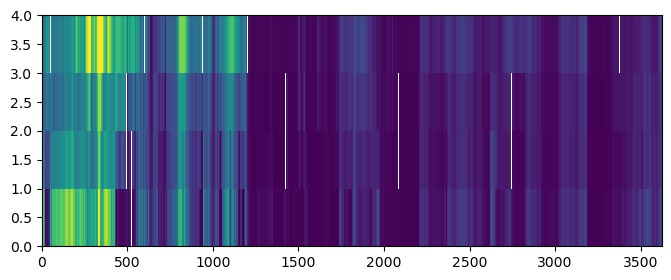

In [40]:
fig, ax = plt.subplots(figsize=(8,3))
plt.pcolormesh(OHT, vmin=0, vmax=50000000)